# MNIST Baselines: Image Transformations


In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import numpy as np

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
# meta-Parameters
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package

# import libraries
from baselines.helpers import *
from baselines.plots import *
from helpers.data_augment import *
from helpers.helpers import get_y_pred_labels, get_accuracy_probas

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11354758193016448313
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4718592
locality {
  bus_id: 1
}
incarnation: 9483025132327871687
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


ModuleNotFoundError: No module named 'baselines'

# Data Import 
Import the data, delete all data in the training set of class 7


In [4]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train, return_counts=True))

label_to_remove = 7

# remove all trainig samples containing a label label_to_remove
x_train = x_train[y_train!=label_to_remove]
y_train = y_train[y_train!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))


In [5]:
batch_size = 128
num_classes = 9
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist-weights.h5')
else :
    model = load_model('mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

OSError: Unable to open file (unable to open file: name = 'mnist-weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

#### Make some predictions for the unseen class

In [ ]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all==label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = np.argmax(y_pred, axis = 1);

for i in range(label_to_remove, 9):
    y_pred_label[y_pred_label == i] = (i+1)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label,return_counts=True)

# visualization
fig = plt.figure(figsize=(7,5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0,10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.savefig("../Figures/pred-count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
# Avarage certitude for unseen class: 1-max_margin
c = []
for i in range(len(y_pred_label)):
    y_probas = np.sort(y_pred[i])  # probabilities for one image
    c.append(y_probas[-1]-y_probas[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100

print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 67.54 %
Std accuracy: 32.05 %
31.32% of all predictions made with an accuracy higher than 0.95%


In [7]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = np.argmax(y_pred_seen, axis = 1);

for i in np.flip(range(label_to_remove,9),axis=0):
    y_pred_label_seen[y_pred_label_seen == i] = (i+1)

c = []
for i in range(len(y_pred_label_seen)):
    y_probas_seen = np.sort(y_pred_seen[i])  # probabilities for one image
    c.append(y_probas_seen[-1]-y_probas_seen[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 97.99 %
Std accuracy: 9.79 %
94.32 % of all predictions made with an accuracy higher than 0.95%


In [8]:
y_pred = model.predict(x_test_all)
y_pred_label = np.argmax(y_pred, axis = 1);

for i in np.flip(range(label_to_remove,9),axis=0):
    y_pred_label[y_pred_label == i] = (i+1)

In [9]:
print(metrics.classification_report(y_pred_label,y_test_all))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       996
          1       1.00      0.98      0.99      1152
          2       0.99      0.84      0.91      1227
          3       1.00      0.86      0.92      1164
          4       0.99      0.97      0.98      1001
          5       0.99      0.99      0.99       890
          6       0.98      0.99      0.99       950
          7       0.00      0.00      0.00         0
          8       0.98      0.98      0.98       973
          9       0.98      0.60      0.75      1647

avg / total       0.99      0.89      0.93     10000



/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Baseline Method
## Confidence from Invariance to Image Transformations
https://arxiv.org/pdf/1804.00657.pdf

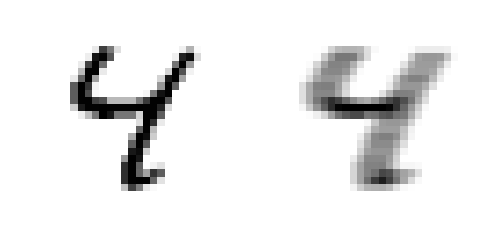

In [10]:
x_aug, _ = augment_images_and_gt(x_test_all, x_test_all, blur=True, force=True)

# visualize an image
im_idx = 6
fig, axes  = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(1-x_test_all[im_idx][...,0], cmap='gray')
[axes[i].set_axis_off() for i in range(2)]
axes[1].imshow(1-x_aug[im_idx][...,0], cmap='gray')

In [11]:
def show_transform(x, save_name=None):
    plt.imshow(1-x, cmap='gray')
    plt.axis('off')
    if save_name is not None:
        plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.show()
    

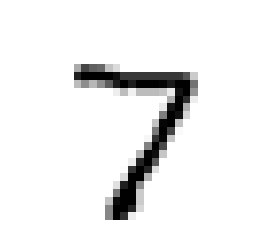

10000/10000 [==============================] - 1s 58us/step


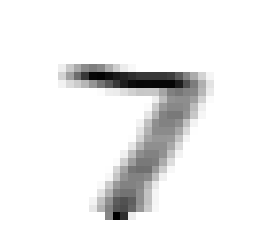

10000/10000 [==============================] - 1s 63us/step


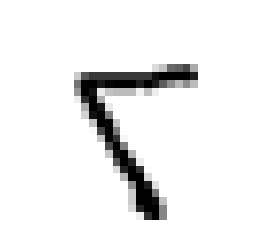

10000/10000 [==============================] - 1s 62us/step


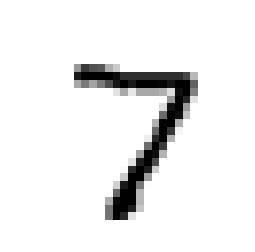

10000/10000 [==============================] - 1s 58us/step


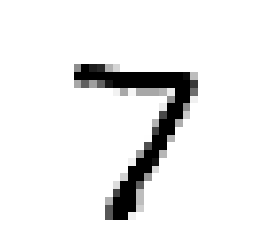

10000/10000 [==============================] - 1s 61us/step


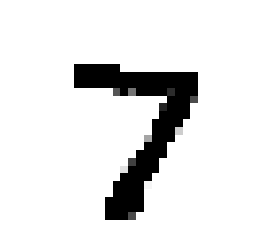

10000/10000 [==============================] - 1s 67us/step


In [12]:
y_preds = []

# original
show_transform(x_test_all[0][...,0], "../Figures/baseline/mnist-orig.pdf")
y_preds.append(model.predict(x_test_all, verbose=1))

# blur
x_aug, _ = augment_images_and_gt(x_test_all, x_test_all, blur=True, force=True)
show_transform(x_aug[0][...,0], "../Figures/baseline/mnist-t_blur.pdf")
y_preds.append(model.predict(x_aug, verbose=1))

# horizontal flipping
x_aug, _ = augment_images_and_gt(x_test_all, x_test_all, rf_h=True, force=True)
show_transform(x_aug[0][...,0], "../Figures/baseline/mnist-t_rot_h.pdf")
y_preds.append(model.predict(x_aug, verbose=1))

# gamma
x_aug, _ = augment_images_and_gt(x_test_all, x_test_all, gamma=.8, force=True)
show_transform(x_aug[0][...,0], "../Figures/baseline/mnist-t_gamma.pdf")

# contrast
y_preds.append(model.predict(x_aug, verbose=1))
x_aug, _ = augment_images_and_gt(x_test_all, x_test_all, contrast=1.5, force=True)
show_transform(x_aug[0][...,0], "../Figures/baseline/mnist-t_constrast.pdf")
y_preds.append(model.predict(x_aug, verbose=1))

# brightness
x_aug, _ = augment_images_and_gt(x_test_all, x_test_all, brightness=10, force=True)
show_transform(x_aug[0][...,0], "../Figures/baseline/mnist-t_brightness.pdf")
y_preds.append(model.predict(x_aug, verbose=1))
#x_aug, _ = augment_images_and_gt(x_test_all, x_test_all, blur=True)

y_preds = np.asarray(y_preds)

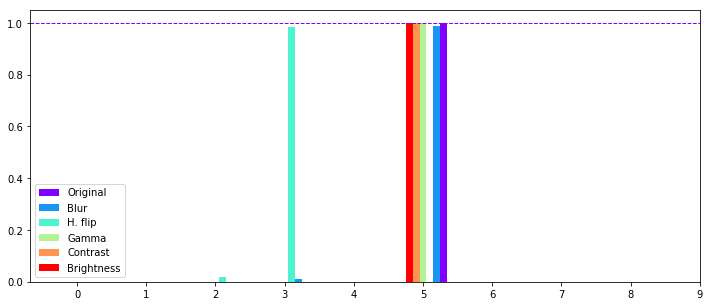

True label: 5


In [13]:
t_names = ['Original','Blur','H. flip','Gamma','Contrast','Brightness']
idx = 15
show_softmax(idx, y_preds, y_true=y_test_all, legend=t_names)

In [14]:
i = np.argsort(np.array([3, 4, 1, 6, 7, 2, 9, 0, 5]))
np.array([8, 7, 2, 4, 3, 1, 0, 6, 5])[i]

array([6, 2, 1, 8, 7, 5, 4, 3, 0])

In [15]:
filt = (np.equal(y_pred_label,y_test_all) == False) & (y_test_all!=label_to_remove)
x_wrong = x_test_all[filt]
y_wrong = y_test_all[filt]
idx_wrong = np.where(filt)[0]

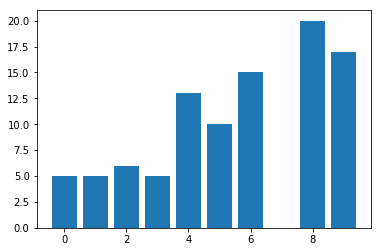

In [16]:
plt.bar(*np.unique(y_wrong,return_counts=True))
plt.show()

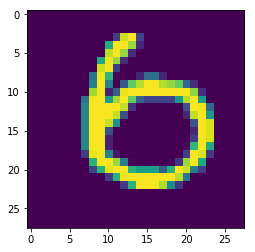

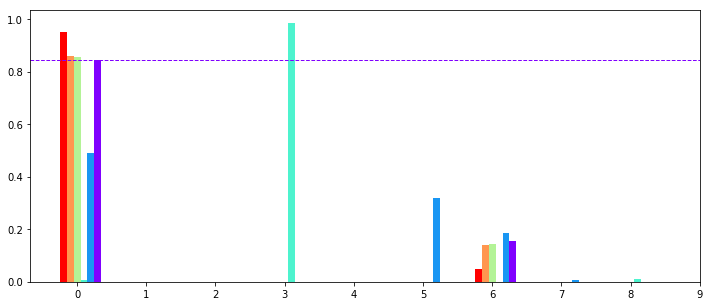

True label: 6


In [17]:
# plot a wrongly predicted image and its softmax output
idx = idx_wrong[1]
plt.imshow(x_test_all[idx][...,0])
plt.show()
show_softmax(idx, y_preds, y_test_all)

In [18]:
# loop all data points
y_pred_t, y_pred_c = reorder_truncate_concatenate(y_preds, 9)

In [19]:
# get training data and labels
x = y_pred_c
y = (np.equal(y_pred_label,y_test_all) == True)*1.

In [20]:
# split training data in train and test part
indices = np.arange(len(x))
x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(x, y, indices, test_size=0.5, random_state=42)

In [21]:
# convert class vectors to binary class matrices
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [22]:
from keras.optimizers import Adam
# KERAS, for GPU use
# Train MLP
n_cl = 2
model_mlp = Sequential()
model_mlp.add(Dense(70, activation='relu', input_shape=(x_train.shape[1:])))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(70, activation='relu'))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(n_cl, activation='softmax'))

model_mlp.summary()

model_mlp.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

batch_size = 200
epochs = 40
history = model_mlp.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model_mlp.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 70)                3850      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 70)                4970      
_________________________________________________________________
dropout_4 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 142       
Total params: 8,962
Trainable params: 8,962
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 5000 samples
Epoch 1/40
5000/5000 [==============================] - 0s 76us/step - loss: 0.4126 - acc: 0

In [23]:
pred = np.argmax(model_mlp.predict(x),-1)
y_pred_label_y = y_test_all*np.equal(y, pred)*1

In [24]:
# show scores for images that were correctly or incorrectly predicted as correct / incorrect
print(metrics.classification_report(y_test_all, y_pred_label_y))

             precision    recall  f1-score   support

          0       0.63      1.00      0.77       980
          1       1.00      0.99      1.00      1135
          2       1.00      0.98      0.99      1032
          3       1.00      0.98      0.99      1010
          4       1.00      0.98      0.99       982
          5       1.00      0.97      0.99       892
          6       1.00      0.96      0.98       958
          7       1.00      0.64      0.78      1028
          8       1.00      0.97      0.98       974
          9       1.00      0.96      0.98      1009

avg / total       0.96      0.94      0.94     10000



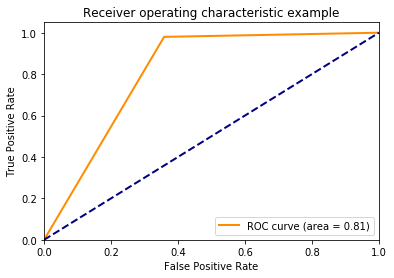

In [25]:
fpr, tpr, rates = metrics.roc_curve(np.asarray(y).astype('int'),np.asarray(pred).astype('int'))
roc_auc = metrics.auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

# TODO plot also for multiclass problem?

### KL Divergence

/opt/conda/envs/python36/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/envs/python36/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


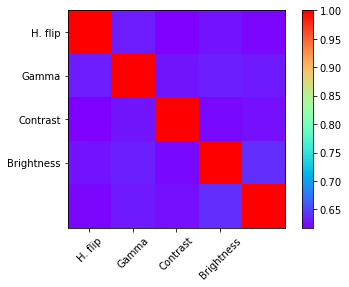

In [26]:
# show KL correlogram
get_kl_correlogram(y_pred_t, labels=t_names[1:])

### Mean Scores


Text(0.5,1,'Mean probability to have a correct prediction in class')

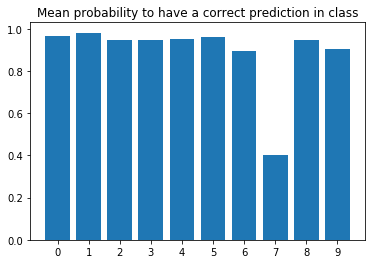

In [27]:
# mean accuracy per class
proba_correct = model_mlp.predict(x_test)[:,1]  # probability to have a correct prediction

av_p = [np.mean(proba_correct[y_test_all[ind_test]==i]) for i in 
        range(10)]


plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean probability to have a correct prediction in class")

Mean accuracy: 94.87 %
Std accuracy: 16.64 %


Text(0.5,1,'Mean certainty by Network')

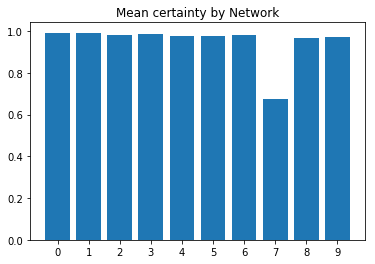

In [28]:
# for comparison: mean margin by network
y_pred = model.predict(x_test_all)

c = get_accuracy_probas(y_pred)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

# get mean proba in all 
av_p = [np.mean(c[y_test_all==i]) for i in range(10)]

plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean certainty by Network")